In [1]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import colors

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

from numba import njit

%load_ext autoreload
%autoreload 2

In [2]:
output = True
L = 9
q = naminoacids

proteome = proteome_path('Human')
seed = 1234
prng = np.random.RandomState(seed)

In [3]:
params = np.load('data/Human_reference_%i.npz'%L)
hi = params['hi']
Jij = params['Jij']

In [41]:
datasets = ['test', 'train', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  load_matrix('data/%s_matrix_L%i.csv.gz' % (dataset, L))

In [42]:
energies = {}
for dataset in datasets:
    energies[dataset] = np.mean([energy_potts(x, hi, Jij) for x in sample_matrices[dataset]])

In [6]:
mcmc_kwargs = dict(nsteps=1e6, nsample=10, nburnin=1e3)

In [46]:
F = Fpotts_thermodynamic_integration(hi, Jij, integration_intervals=3, mcmc_kwargs=mcmc_kwargs)

In [8]:
Suni = np.log(20)*L
'%e'%np.exp(Suni)

'5.120000e+11'

In [10]:
fis = frequencies(sample_matrices['train'], num_symbols=q)

In [11]:
Sind_global = L*scipy.stats.entropy(np.mean(fis, axis=0))
'%e'%np.exp(Sind_global)

'2.032950e+11'

In [12]:
def calc_Sind(fis):
    return np.sum(scipy.stats.entropy(fis.T))

In [13]:
Sind = calc_Sind(fis)
'%e'%np.exp(Sind)

'2.032795e+11'

In [47]:
Smaxent = np.mean(energies['train']) - F
'%e'%np.exp(Smaxent)

'1.669752e+11'

In [17]:
Sind*np.log2(np.exp(1))/L, Smaxent*np.log2(np.exp(1))/L

(4.1738526076016536, 4.142554083355258)

In [20]:
df = pd.read_csv('../kmerentropy/data/entropy.csv')
np.array(df['Human'])/np.arange(1, 6)

array([4.17756346, 4.16934288, 4.16129658, 4.14931991, 4.11369582])

In [24]:
(Suni-Sind)*np.log2(np.exp(1)), (Sind-Smaxent)*np.log2(np.exp(1))

(1.3326793855713739, 0.2816867182175577)

In [25]:
L = 9
mi = pd.read_csv('../pfam/data/mutualinformation_nozf.csv', index_col=0, usecols=(1, 2))
mi = np.asarray(mi.loc[:L-2]).flatten()
np.sum(mi*(L-np.arange(1, L)))

0.33534763650457045

# Global model

In [50]:
sample_matrices['model_global'] =  load_matrix('../globalmaxent/data/model_matrix.csv.gz')
params = np.load('../globalmaxent/data/Human_L%i.npz'%L)
h = params['h']
J = params['J']

In [48]:
Fcov = Fcov_thermodynamic_integration(h, J, L, integration_intervals=3, mcmc_kwargs=mcmc_kwargs)

In [52]:
Scov = np.mean([energy_cov(x, h, J) for x in sample_matrices['model_global']])-Fcov
'%e'%np.exp(Scov)

'1.822727e+11'

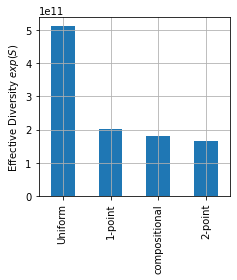

In [66]:
data = np.exp(np.array([Suni, Sind, Scov, Smaxent]))
label = ['Uniform', '1-point', 'compositional', '2-point']
fig, ax = plt.subplots(figsize=(3.4, 4.0))
pd.Series(data=data, index=label).plot.bar()
#plt.ylim(0,6e11)
plt.grid()
plt.ylabel('Effective Diversity $exp(S)$')
fig.tight_layout()
fig.savefig('entropies.png')
fig.savefig('../../paper/images/diversity_reduction.pdf')

In [55]:
(data[1:]-data[:-1])/data[:-1], (data[3]-data[0])/data[0]

(array([-0.60296981, -0.10333928, -0.08392667]), -0.6738766347405952)